In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import dlib
import cv2
from math import sqrt
from mtcnn import MTCNN
import pickle
from imutils import face_utils
import numpy as np
import os
import torch
import math
from google.colab.patches import cv2_imshow
print("done")

done


In [ ]:
landmark_detector = dlib.shape_predictor('/content/drive/MyDrive/weight/shape_predictor_68_face_landmarks.dat')
detector = MTCNN() #Load face detector
print("done")

done


In [ ]:
def draw_line(image, x1,y1,x2,y2,color=(193, 42, 77),size = 2) :
    cv2.line(image, (x1,y1), (x2,y2), color, size)
print("done")

done


In [ ]:
def center_eye(landmark) :
    x = []
    y = []
    center_left =[]
    center_right =[]
    for i in range(36,48):
        x.append(landmark[i][0])
        y.append(landmark[i][1])
    center_left.append((x[0]+x[3])/2)
    center_left.append((y[0]+y[3])/2)
    center_right.append((x[6]+x[9])/2)
    center_right.append((y[0]+y[3])/2)
    return center_left, center_right
print("done")

done


In [ ]:
def tinhanpha(center_left, center_right) :
  anpha = math.asin((center_left[1]-center_right[1])/
                    (sqrt((center_left[0]-center_right[0])**2+(center_left[1]-center_right[1])**2)))/math.pi*180
  return anpha

In [ ]:
def xoayanh(image, anpha) :
  height, width = image.shape[:2]
  center = (width/2, height/2)
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=anpha, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
  return rotated_image

In [ ]:
def crop_anh(glass, anpha) :
  image_white = np.zeros([512,512,3],dtype=np.uint8)
  image_white.fill(255)
  # or img[:] = 255
  h, w, c = glass.shape
  w_new = w*3
  h_new = h*3
  image_white = cv2.resize(image_white, (int(w_new),int(h_new)))
  image_white[h:h*2, w:w*2] = glass
  image_white = xoayanh(image_white, anpha)
  glass_new = image_white[int(h/2):int(h*2.5),w:w*2]
  return glass_new

In [ ]:
def deo_kinh(image, glass, x1, y1, width, height) :
  final_image = image

  x2 = x1 + width
  y2 = y1 + height
  

  # face = image[y1:y2, x1:x2]

  # Trích xuất landmark băng dlib
  landmark = landmark_detector(image, dlib.rectangle(x1,y1,x2,y2))
  landmark = face_utils.shape_to_np(landmark)

  # lấy tâm 2 mắt 
  center_left, center_right = center_eye(landmark)
  print("left = ", center_left)
  print("right = ", center_right)
  anpha = tinhanpha(landmark[36], landmark[44])
  glass_image = crop_anh(glass, anpha)
  
  if len(center_left) > 0 and len(center_right) >0 : # có cả 2 mắt
    # tính toán toạ độ, kích thước kính
    glass_width_resize = 2.5 * abs(center_left[0] - center_right[0]) # độ rộng của kính = 2.5* khoảng cách tâm 2 mắt
    scale_factor = glass_width_resize / glass_image.shape[1]
    resize_glasses = cv2.resize(glass_image, None, fx= scale_factor, fy=scale_factor)
    # tính toạ độ kính
    glass_x = center_left[0] - 0.28 * resize_glasses.shape[1]
    glass_y = center_left[1] - 0.5 * resize_glasses.shape[0]
    # vẽ kính lên mặt
    # tạo ảnh trắng = ảnh img
    overlay_image = np.ones(image.shape, np.uint8)  * 255 
    # vẽ kính lên vùng màu trắng
    overlay_image [int(glass_y): int(glass_y + resize_glasses.shape[0]),
                                        int(glass_x): int(glass_x + resize_glasses.shape[1])] = resize_glasses 
    gray_overlay = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_overlay, 127, 255, cv2.THRESH_BINARY)
    # Lấy phần background và face (trừ phần kính mắt) ra khỏi ảnh gốc
    background = cv2.bitwise_and(image, image, mask = mask)

    mask_inv = cv2.bitwise_not(mask)

    # Lấy phần kính ra khỏi overlay
    glasses = cv2.bitwise_and(overlay_image, overlay_image, mask=mask_inv)

    final_image = cv2.add(background, glasses)

  return final_image


0 [222, 96, 71, 96]
left =  [253.0, 130.0]
right =  [282.5, 130.0]
1 [331, 171, 67, 83]
left =  [350.0, 202.0]
right =  [379.5, 202.0]


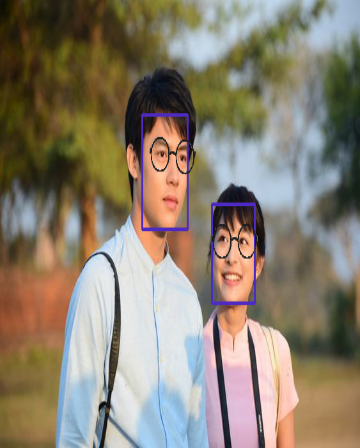

In [ ]:
image_ = cv2.imread("/content/drive/MyDrive/dataAI/Nau/person/2nguoi.jpg")
glass_image = cv2.imread("/content/drive/MyDrive/dataAI/Nau/glass/kinh_01.png")
res = image_
results = detector.detect_faces(image_)
len(results)
for i in range(len(results)) : 
  result = results[i]

  x1, y1, width, height = result['box']
  print(i, result['box'])
  x1, y1 = abs(x1), abs(y1)
  x2 = x1 + width
  y2 = y1 + height
  # vẽ 4 đường bao quanh mặt
  cv2.line(res, (x1,y1), (x2,y1), (193, 42, 77), 2)
  cv2.line(res, (x2,y1), (x2,y2), (193, 42, 77), 2)
  cv2.line(res, (x2,y2), (x1,y2), (193, 42, 77), 2)
  cv2.line(res, (x1,y2), (x1,y1), (193, 42, 77), 2)
  res = deo_kinh(res, glass_image, x1, y1, width, height)
res = cv2.resize(res, (360,448))
cv2_imshow(res)

In [ ]:
cap = cv2.VideoCapture(0)
i = 0
path_save = "person_glass"
while True:
    ret, frame = cap.read()
    if not ret :
        continue
    #frame =cv2.resize(frame,dsize=None,fx=1,fy=1)
    i+=1
    path = os.path.join(path_save,str(i)+".jpg")

    results = detector.detect_faces(frame)

    for i in range(len(results)) : 
      result = results[i]
      x1, y1, width, height = result['box']
      print(i, result['box'])
      x1, y1 = abs(x1), abs(y1)
      x2 = x1 + width
      y2 = y1 + height
      cv2.line(res, (x1,y1), (x2,y1), (193, 42, 77), 2)
      cv2.line(res, (x2,y1), (x2,y2), (193, 42, 77), 2)
      cv2.line(res, (x2,y2), (x1,y2), (193, 42, 77), 2)
      cv2.line(res, (x1,y2), (x1,y1), (193, 42, 77), 2)
      frame = deo_kinh(frame, glass_image, x1, y1, width, height)
    cv2.putText(frame, 'ITPTIT', (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
    if i %5 ==0 :
      cv2.imwrite(path, frame)
    cv2.imshow('Facevideo', frame)
    key = cv2.waitKey(5)
    if key == ord('q'):
        break
cap.release()
cv2.destroyAllWindows

In [ ]:
print(os.path.join(path_save,str(12)+".jpg"))